---
title: How to perform correlation analysis on uncertain data
subtitle: Using Monte Carlo simulations to generate distributions of correlation coefficients
summary: Correlation analysis is a fundamental technique of statistics that allows us to investigate how variables are related to each other. But what if our data possess uncertainty? In this post I'll show how a simple Monte Carlo simulation can let us generate distributions of correlation coefficients, allowing us to interpret the results of correlation analysis with more strength.
authors:
- admin
tags: []
categories: []
date: "2021-01-16T00:00:00Z"
lastMod: "2021-01-16T00:00:00Z"
featured: false
draft: false

# Featured image
# To use, add an image named `featured.jpg/png` to your page's folder. 
image:
  caption: ""
  focal_point: ""

# Projects (optional).
#   Associate this post with one or more of your projects.
#   Simply enter your project's folder or file name without extension.
#   E.g. `projects = ["internal-project"]` references 
#   `content/project/deep-learning/index.md`.
#   Otherwise, set `projects = []`.
projects: []
---

## A quick intro to correlation analysis with a toy example

Correlation analysis is a fundamental technique in statistics to measure relationships between variables. For example, let's say we wanted to investigate possible correlations between human height and weight. We could imagine going around with a measuring tape and a scale and collecting data on a few hundred people to generate a plot that looks something like this:

In [18]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import spearmanr
%matplotlib inline
plt.style.use('ggplot')

Text(0, 0.5, 'weight (lbs)')

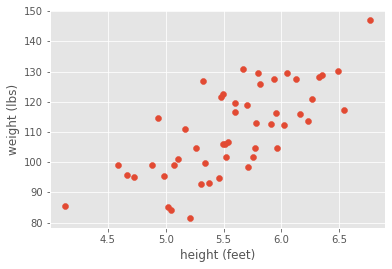

In [52]:
#Generate some synthetic height/weight data with positive correlation
N = 50 #Number of individuals
mean_height = 5.5 #Let's say the average height is 5.5 feet
sigma_height = 0.5 #Standard deviation of 0.5 feet
height = np.random.normal(mean_height,sigma_height, N)

#Let's assume a linear relationship between weight and height
R = 20 #Scaling factor between weight in lbs and height in feet
weight = R * height
weight = weight + np.random.normal(0,10,N) #Let's add some scatter

#Plot the results
plt.figure()
plt.scatter(height,weight)
plt.xlabel('height (feet)')
plt.ylabel('weight (lbs)')

Looking at the scatter plot, we would clearly conclude that height and weight are positively correlated. Although we generated this synthetic data with a linear relationship, let's be agnostic and measure the correlation with a non-parametric metric: the Spearman correlation coefficient.

If you're not familiar with the Spearman correlation coefficient, the relevant information is that it essentially doesn't assume an underlying relationship between your two variables, instead producing a generic measure of positive or negative correlation. The Spearman correlation coefficient takes values between negative and positive one, corresponding to negative or positive correlation.

In [30]:
#Calculate the Spearman correlation coefficient
rho,p = spearmanr(height,weight)
print('Spearman correlation coefficient is ' + str(rho) + ' with p-value = ' + str(p))

Spearman correlation coefficient is 0.7085234093637454 with p-value = 8.587222711685343e-09


As expected, the Spearman correlation coefficient is around 0.7, indicating a  positive correlation. We also have a p-value that is extremely small, indicating the calculation is significant.

## Accounting for measurement uncertainty

What if our measurement system wasn't very good? For example, what if our scale was all over the place? If we had substantial error, we might not be as confident with our strong positive correlation. For example, what if our data looked like this?

Text(0, 0.5, 'weight (lbs)')

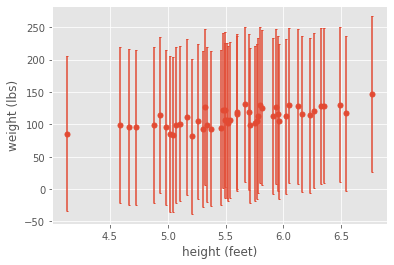

In [53]:
#Show the same scatterplot but now with errorbars
y_err_high = 120

#Plot results
plt.figure()
plt.errorbar(height,weight,yerr=y_err_high,marker='o',\
             ms=5,capsize=1,linestyle='')
plt.xlabel('height (feet)')
plt.ylabel('weight (lbs)')

Although our analysis on the mean measurements indicated a strong positive correlation, if we account for measurement error, we would clearly conclude that our measurements aren't good enough to detect anything significant. On the other hand, if our measurement error were small enough, then intuitively we would trust our correlation analysis. For example, if the error were smaller, then we could easily see a correlation, even by eye:

Text(0, 0.5, 'weight (lbs)')

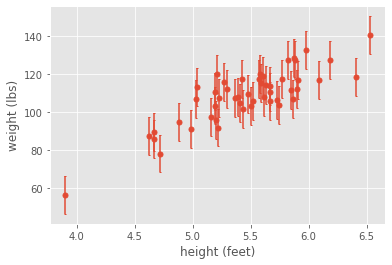

In [50]:
#Data with smaller error
y_err_low = 10

#Plot results
plt.figure()
plt.errorbar(height,weight,yerr=y_err_low,marker='o',\
             ms=5,capsize=1,linestyle='')
plt.xlabel('height (feet)')
plt.ylabel('weight (lbs)')

## Using Monte Carlo simulations to generate a distribution of correlation coefficients

Given the challenges posed by measurement uncertainty, we'd like to be able to quantify our downstream uncertainty in our Spearman correlation coefficient. That is, can we introduce error bars into the correlation coefficient itself, given knowledge of the error bars on the individual measurements?

One simple way to do this is by using a Monte Carlo simulation. Essentially, we assume an underlying distribution of measured weights and simulate many random instances of our dataset from that distribution. We then calculate the Spearman correlation coefficient for each dataset, generating a distribution in the correlation coefficient. That distribution then quantifies our uncertainty in the correlation coefficient, which is much more informative than having a single value without a sense of uncertainty!

Note that we're not making any statements about the true distribution of heights and/or weights. Rather, we're assuming that measurement error leads to a distribution in *measured* heights and/or weights.

For simplicity, let's assume that heights possess no measurement error and weights are Gaussian distributed with standard deviation equal to our measurement error. We then simulate many instances of our measurement and calculate a Spearman correlation coefficient for each one. First, let's do this in the case with high amounts of measurement error.

In [71]:
#Monte Carlo simulation
n = 10000 #Let's do 10,000 simulations
rho_sim = np.zeros(n) #Initialize array of Spearman correlation coefficients
p_sim = np.zeros(n) #Initialize array of p-values

for i in range(n):
    #Generate random weights using mean weights with measurement error
    weight_sim = np.random.normal(weight,y_err_high,N)
    
    #Calculate correlation coefficient and p-value
    rho_sim[i],p_sim[i] = spearmanr(height,weight_sim)

(0.0, 1.0)

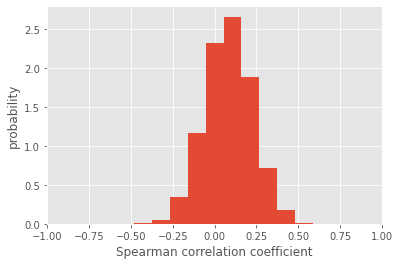

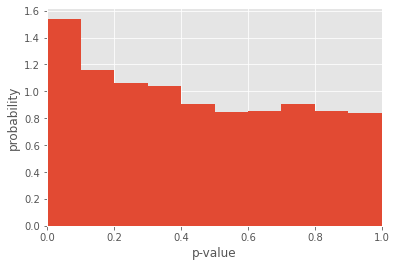

In [72]:
#Plot results
plt.figure()
plt.hist(rho_sim,density=True)
plt.xlabel('Spearman correlation coefficient')
plt.ylabel('probability')
plt.xlim((-1,1))

plt.figure()
plt.hist(p_sim,density=True)
plt.xlabel('p-value')
plt.ylabel('probability')
plt.xlim((0,1))


Although the mean of the distribution of Spearman correlation coefficients is slightly positive, we see that the distribution is incredibly wide, taking both negative and positive values! So, due to the incredibly high amounts of measurement noise, our correlation analysis is completely bogus. That's even more confirmed by looking at the distribution of p-values, which is all over the place.

While this may seem obvious given even a cursory examination of the data, this Monte Carlo method is powerful in that it gives us a quantitative estimate of our uncertainty. For example, let's repeat the same analysis in the case with low amounts of measurement noise.

In [73]:
#Monte Carlo simulation
n = 10000 #Let's do 10,000 simulations
rho_sim = np.zeros(n) #Initialize array of Spearman correlation coefficients
p_sim = np.zeros(n) #Initialize array of p-values

for i in range(n):
    #Generate random weights using mean weights with measurement error
    weight_sim = np.random.normal(weight,y_err_low,N)
    
    #Calculate correlation coefficient and p-value
    rho_sim[i],p_sim[i] = spearmanr(height,weight_sim)

(0.0, 0.1)

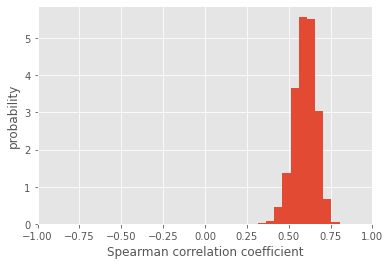

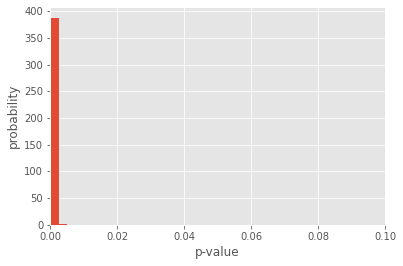

In [75]:
#Plot results
plt.figure()
plt.hist(rho_sim,density=True)
plt.xlabel('Spearman correlation coefficient')
plt.ylabel('probability')
plt.xlim((-1,1))

plt.figure()
plt.hist(p_sim,density=True)
plt.xlabel('p-value')
plt.ylabel('probability')
plt.xlim((0,0.1))

In this case, the distribution of Spearman correlation coefficients is much more constrained to positive values, and the associated p-values are also significant. More importantly, we have a sense of how uncertain our correlation coefficient is. By taking the standard deviation of the distribution, we can succintly report the mean and uncertainty of our analysis:

In [64]:
print('Spearman correlation coefficient is ' + str(np.mean(rho_sim)) + ' +/- ' \
     + str(np.std(rho_sim)))

Spearman correlation coefficient is 0.5974073757503001 +/- 0.06584519864718974
